Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   buying           1728 non-null   object
 1   maint            1728 non-null   object
 2   doors            1728 non-null   object
 3   persons          1728 non-null   object
 4   lug_boot         1728 non-null   object
 5   safety           1728 non-null   object
 6   target_variable  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB

Missing Values:
buying             0
maint              0
doors              0
persons            0
lug_boot           0
safety             0
target_variable    0
dtype: int64

Mean Squared Error: 0.04398563504219055
R^2 Score: 0.9263210892677307


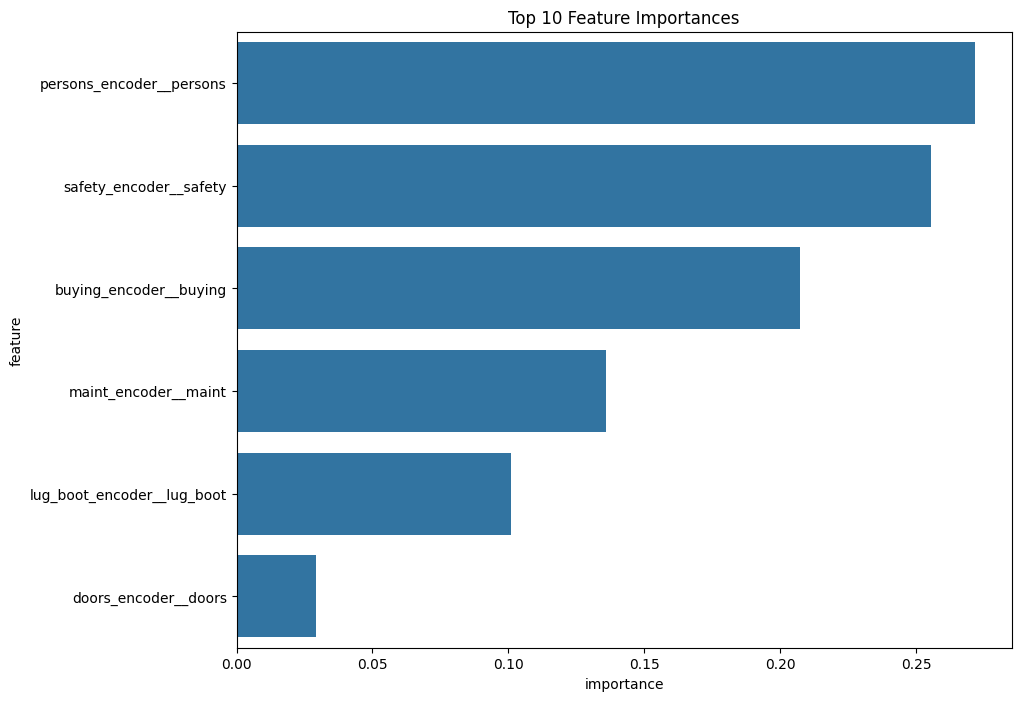

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

# 1. Data Loading and Exploration
data = pd.read_csv("/content/drive/MyDrive/Data_set/ML project/car_evaluation.csv",
                   names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target_variable'])

# Display basic info
print("Data Info:")
data.info()
print("\nMissing Values:")
print(data.isnull().sum())

# 2. Data Preprocessing
X = data.drop("target_variable", axis=1)

# **Fixing the issue: Mapping target_variable categories to numeric values**
target_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
y = data['target_variable'].map(target_mapping)  # Convert categorical target to numerical

# Ensure there are no NaN values in y
if y.isnull().sum() > 0:
    raise ValueError("NaN values detected in target variable after mapping!")

# Define mappings for ordinal encoding
buying_mapping = ['low', 'med', 'high', 'vhigh']
maint_mapping = ['low', 'med', 'high', 'vhigh']
doors_mapping = ['2', '3', '4', '5more']
persons_mapping = ['2', '4', 'more']
lug_boot_mapping = ['small', 'med', 'big']
safety_mapping = ['low', 'med', 'high']

preprocessor = ColumnTransformer(
    transformers=[
        ('buying_encoder', OrdinalEncoder(categories=[buying_mapping]), ['buying']),
        ('maint_encoder', OrdinalEncoder(categories=[maint_mapping]), ['maint']),
        ('doors_encoder', OrdinalEncoder(categories=[doors_mapping]), ['doors']),
        ('persons_encoder', OrdinalEncoder(categories=[persons_mapping]), ['persons']),
        ('lug_boot_encoder', OrdinalEncoder(categories=[lug_boot_mapping]), ['lug_boot']),
        ('safety_encoder', OrdinalEncoder(categories=[safety_mapping]), ['safety'])
    ],
    remainder='passthrough'
)

# Apply transformation
X_processed = preprocessor.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)

# Convert to sparse matrix for compatibility
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

# 3. Model Building
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# 4. Prediction and Evaluation
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 5. Feature Importance
feature_names = preprocessor.get_feature_names_out()
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()
